In [0]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from google.colab import drive

In [2]:
DIRECTORY = "/content/drive/My Drive/Colab Notebooks/Kaggle/data/"
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [0]:
pd.options.display.max_columns = 50

In [0]:
h = 28 
max_lags = 364 + 364 + 1 
tr_last = 1913 
fday = datetime(2016,4, 25) 
FIRST_DAY = 1 

params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 1200,
    'num_leaves': 128,
    "min_data_in_leaf": 100,
}

VERSION = "_kaggle_RMSSE_magic_model6_model" 

In [0]:
def create_dt(is_train = True, nrows = None, first_day = 1200, tr_last=tr_last):
    prices = pd.read_csv(DIRECTORY + "data/sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv(DIRECTORY + "data/calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv(DIRECTORY + "data/sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

In [0]:
def create_fea(dt):
    lags = [7, 28, 364]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28, 364]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day"
    }
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [0]:
df = create_dt(is_train=True, first_day= FIRST_DAY)

In [9]:
create_fea(df)
df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,lag_364,rmean_7_7,rmean_28_7,rmean_364_7,rmean_7_28,rmean_28_28,rmean_364_28,rmean_7_364,rmean_28_364,rmean_364_364,week,quarter,mday
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,29
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,30
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,31
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46027952,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98,0.0,1.0,1.0,1.000000,0.714286,0.714286,0.928571,1.250000,1.214286,0.637363,0.659341,0.991758,16,2,24
46027953,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,0.0,2.0,0.0,0.857143,1.142857,0.000000,1.035714,1.107143,0.000000,1.060440,1.002747,0.362637,16,2,23
46027954,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,4.0,0.0,0.714286,1.571429,0.000000,1.035714,1.250000,0.000000,1.063187,1.013736,0.357143,16,2,24
46027955,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,0.0,1.0,0.000000,2.285714,2.428571,1.821429,1.785714,1.857143,1.774725,1.774725,1.585165,16,2,23


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 37 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             object        
 1   item_id        int16         
 2   dept_id        int16         
 3   store_id       int16         
 4   cat_id         int16         
 5   state_id       int16         
 6   d              object        
 7   sales          float32       
 8   date           datetime64[ns]
 9   wm_yr_wk       int16         
 10  weekday        int16         
 11  wday           int16         
 12  month          int16         
 13  year           int16         
 14  event_name_1   int16         
 15  event_type_1   int16         
 16  event_name_2   int16         
 17  event_type_2   int16         
 18  snap_CA        float32       
 19  snap_TX        float32       
 20  snap_WI        float32       
 21  sell_price     float32       
 22  lag_7          float32       
 23  lag_2

In [11]:
df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,lag_364,rmean_7_7,rmean_28_7,rmean_364_7,rmean_7_28,rmean_28_28,rmean_364_28,rmean_7_364,rmean_28_364,rmean_364_364,week,quarter,mday
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,29
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,30
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,31
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46027952,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98,0.0,1.0,1.0,1.000000,0.714286,0.714286,0.928571,1.250000,1.214286,0.637363,0.659341,0.991758,16,2,24
46027953,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,0.0,2.0,0.0,0.857143,1.142857,0.000000,1.035714,1.107143,0.000000,1.060440,1.002747,0.362637,16,2,23
46027954,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,4.0,0.0,0.714286,1.571429,0.000000,1.035714,1.250000,0.000000,1.063187,1.013736,0.357143,16,2,24
46027955,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,0.0,1.0,0.000000,2.285714,2.428571,1.821429,1.785714,1.857143,1.774725,1.774725,1.585165,16,2,23


In [12]:
df.dropna(inplace = True)
df.shape

(24375141, 37)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24375141 entries, 12729751 to 46027956
Data columns (total 37 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             object        
 1   item_id        int16         
 2   dept_id        int16         
 3   store_id       int16         
 4   cat_id         int16         
 5   state_id       int16         
 6   d              object        
 7   sales          float32       
 8   date           datetime64[ns]
 9   wm_yr_wk       int16         
 10  weekday        int16         
 11  wday           int16         
 12  month          int16         
 13  year           int16         
 14  event_name_1   int16         
 15  event_type_1   int16         
 16  event_name_2   int16         
 17  event_type_2   int16         
 18  snap_CA        float32       
 19  snap_TX        float32       
 20  snap_WI        float32       
 21  sell_price     float32       
 22  lag_7          float32       
 23

In [14]:
df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,lag_364,rmean_7_7,rmean_28_7,rmean_364_7,rmean_7_28,rmean_28_28,rmean_364_28,rmean_7_364,rmean_28_364,rmean_364_364,week,quarter,mday
12729751,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_728,0.0,2013-01-25,11252,0,7,1,2013,0,0,0,0,0.0,0.0,0.0,0.46,0.0,0.0,8.0,0.000000,0.000000,11.000000,0.000000,0.000000,9.607142,3.236264,3.763736,6.824176,4,1,25
12729758,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_728,0.0,2013-01-25,11252,0,7,1,2013,0,0,0,0,0.0,0.0,0.0,1.77,1.0,1.0,3.0,1.857143,1.285714,0.714286,1.571429,1.750000,1.821429,1.667582,1.697802,1.821429,4,1,25
12729765,HOBBIES_1_010_CA_1_validation,9,0,0,0,0,d_728,1.0,2013-01-25,11252,0,7,1,2013,0,0,0,0,0.0,0.0,0.0,2.97,0.0,0.0,1.0,0.714286,0.428571,1.000000,0.678571,0.750000,0.714286,0.895604,0.887363,0.543956,4,1,25
12729779,HOBBIES_1_012_CA_1_validation,11,0,0,0,0,d_728,0.0,2013-01-25,11252,0,7,1,2013,0,0,0,0,0.0,0.0,0.0,6.52,0.0,2.0,0.0,0.714286,0.857143,0.285714,0.607143,0.535714,0.464286,0.420330,0.420330,0.552198,4,1,25
12729800,HOBBIES_1_015_CA_1_validation,14,0,0,0,0,d_728,0.0,2013-01-25,11252,0,7,1,2013,0,0,0,0,0.0,0.0,0.0,0.72,1.0,1.0,0.0,3.000000,2.285714,7.714286,3.071429,3.928571,5.821429,5.203297,5.310440,6.722528,4,1,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46027952,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98,0.0,1.0,1.0,1.000000,0.714286,0.714286,0.928571,1.250000,1.214286,0.637363,0.659341,0.991758,16,2,24
46027953,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,0.0,2.0,0.0,0.857143,1.142857,0.000000,1.035714,1.107143,0.000000,1.060440,1.002747,0.362637,16,2,23
46027954,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,4.0,0.0,0.714286,1.571429,0.000000,1.035714,1.250000,0.000000,1.063187,1.013736,0.357143,16,2,24
46027955,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,0.0,1.0,0.000000,2.285714,2.428571,1.821429,1.785714,1.857143,1.774725,1.774725,1.585165,16,2,23


In [0]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

In [0]:
np.random.seed(42)

fake_valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
train_data = lgb.Dataset(X_train , label = y_train, 
                         categorical_feature=cat_feats, free_raw_data=False)
fake_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds],
                              categorical_feature=cat_feats,
                 free_raw_data=False)

In [17]:
del df, X_train, y_train ; gc.collect()

0

In [18]:
%%time
m_lgb = lgb.train(params, train_data) 

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


CPU times: user 3h 43min 5s, sys: 13.7 s, total: 3h 43min 19s
Wall time: 58min 57s


In [19]:
m_lgb.save_model(DIRECTORY + "models/modelv_" + str(VERSION) + ".lgb")

In [0]:
# #load model
# m_lgb = lgb.Booster(model_file=DIRECTORY + "models/modelv_" + str(VERSION) + ".lgb")

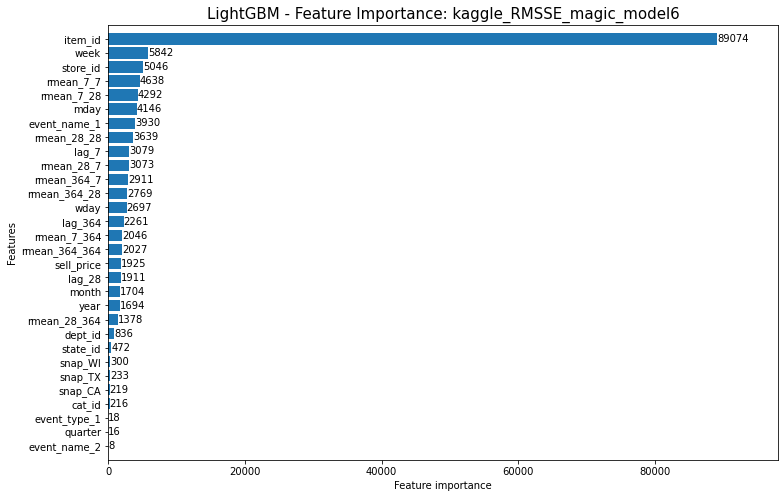

In [21]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18.0, 4)
%matplotlib inline
 
fig, ax = plt.subplots(figsize=(12,8))
lgb.plot_importance(m_lgb, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance: " + str(VERSION), fontsize=15)
plt.savefig(DIRECTORY + "models/modelv_" + str(VERSION) + ".png")

In [0]:
%%time

alphas = [1.028, 1.023, 1.018] 
weights = [1/len(alphas)]*len(alphas)
sub = 0.

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    te = create_dt(False)
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        print(tdelta, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day , train_cols]
        te.loc[te.date == day, "sales"] = alpha*m_lgb.predict(tst)

    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)

sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv(DIRECTORY + "submissions/submission_v" + str(VERSION) + ".csv",index=False)

0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00


In [0]:
sub

In [0]:
def create_test():
  """
  Create test set starting from last day + 1 used for
  trainining. We split our trining data into test and train,
  we use the last 28 days as test set, and all the previous
  as train set. Last day of train data is 1913 - 28,
  first day of test is 1913 - 28 + 1 )
  """
  df_test2 = create_dt(is_train=True, first_day= 1913-27, tr_last=1913)
  cols = [f"F{i}" for i in range(1,29)]
  df_test2["F"] = [f"F{rank}" for rank in df_test2.groupby("id")["id"].cumcount()+1]
  df_test2 = df_test2.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
  df_test2.fillna(0., inplace = True)
  df_test2.sort_values("id", inplace = True)
  df_test2.reset_index(drop=True, inplace = True)
  return df_test2

def is_testset_correct(test_set):
  """
  Run only if check is needed, memory consumption.
  Given a test_set (in submission format) we created,
  we check if it actually match the last 28 days of
  the true sales train validation data.
  Return 0 if perfect match.
  """
  true_sales = pd.read_csv(DIRECTORY + "data/sales_train_validation.csv")
  dcols = [f"d_{i}" for i in range(1913-27, 1914)]
  fcols = [f"F{i}" for i in range(1, 29)]
  true_sales = true_sales[["id"] + dcols]
  true_sales.sort_values("id", inplace = True)
 
  test_set = test_set[["id"] + fcols]
  value = np.sum(test_set[fcols].values - true_sales[dcols].values)
  return value
 
def get_rmse(predictions):
  """
  Given a prediction (submission format),
  return RMSE using the create_test function
  (last 28 days of the sales_train_validation.csv
  in submission format)
  """
  test_data = create_test().iloc[:,1:]
  predictions = predictions.iloc[:,1:]
  error = mean_squared_error(predictions, test_data, squared=False)
  return error

In [0]:
filename = DIRECTORY + "submissions/submission_v" + str(VERSION)
threshold = 0.8
x = pd.read_csv(filename + ".csv")
x2 = pd.read_csv(filename + ".csv")

import math
for col in x.iloc[:,1:]:
  entries = x[col]
  print(col)

  for i, entry in enumerate(x[col]):
    fractional = math.modf(entry)[0]
    integer = math.modf(entry)[1]
    if fractional > threshold:
      x[col].iloc[i] = integer + 1

x.to_csv(filename + "RoundUP_" + str(threshold) + ".csv",index=False)